#  **Importing Libraries**


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import RobustScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.model_selection import TimeSeriesSplit
import yfinance as yf
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import warnings
warnings.filterwarnings('ignore')

print(" All libraries imported successfully!")
print(f"PyTorch version: {torch.__version__}")

 All libraries imported successfully!
PyTorch version: 2.6.0+cu124


# **Preprocessing**

In [2]:
#  Download Apple stock data
def download_stock_data(ticker='AAPL', start_date='2010-01-01', end_date='2023-12-31'):
    data = yf.download(ticker, start=start_date, end=end_date)
    print(f" Downloaded {len(data)} records for {ticker}")
    return data

# Download data
stock_data = download_stock_data('AAPL')
stock_data.head()

[*********************100%***********************]  1 of 1 completed

 Downloaded 3522 records for AAPL


Price,Close,High,Low,Open,Volume
Ticker,AAPL,AAPL,AAPL,AAPL,AAPL
Date,,,,,
2010-01-04,6.418384,6.433080,6.369499,6.400989,493729600
2010-01-05,6.429482,6.465771,6.395591,6.436080,601904800
2010-01-06,6.327211,6.454973,6.320613,6.429480,552160000
2010-01-07,6.315514,6.358101,6.269627,6.350604,477131200
2010-01-08,6.357502,6.358102,6.269929,6.307117,447610800


In [3]:
#  Data Cleaning and Feature Engineering
def prepare_stock_data(data):
    # Create copy
    df = data.copy()
    
    # Create additional features
    df['Daily_Return'] = df['Close'].pct_change()
    df['HL_Pct'] = (df['High'] - df['Low']) / df['Close'] * 100.0
    df['OC_Pct'] = (df['Close'] - df['Open']) / df['Open'] * 100.0
    
    # Moving averages
    df['MA5'] = df['Close'].rolling(window=5).mean()
    df['MA20'] = df['Close'].rolling(window=20).mean()
    df['MA50'] = df['Close'].rolling(window=50).mean()
    
    # Volatility
    df['Volatility'] = df['Daily_Return'].rolling(window=20).std()
    
    # Drop NaN values
    df.dropna(inplace=True)
    
    return df

processed_data = prepare_stock_data(stock_data)
print(" Processed Data Shape:", processed_data.shape)
processed_data.head()

 Processed Data Shape: (3473, 12)


Price,Close,High,Low,Open,Volume,Daily_Return,HL_Pct,OC_Pct,MA5,MA20,MA50,Volatility
Ticker,AAPL,AAPL,AAPL,AAPL,AAPL,,,,,,,
Date,,,,,,,,,,,,
2010-03-16,6.731488,6.747383,6.673306,6.723391,446908000,0.002725,1.100463,0.120436,6.749364,6.352208,6.206868,0.012642
2010-03-17,6.721594,6.791473,6.696102,6.744987,450956800,-0.001470,1.418873,-0.346817,6.745045,6.384553,6.212933,0.012552
2010-03-18,6.737488,6.747984,6.676306,6.720992,342109600,0.002365,1.063878,0.245438,6.739947,6.417124,6.219093,0.012546
2010-03-19,6.665509,6.755182,6.634918,6.741686,559445600,-0.010683,1.804280,-1.129946,6.713855,6.447984,6.225859,0.012797
2010-03-22,6.740486,6.777975,6.602527,6.612125,456419600,0.011249,2.602898,1.941303,6.719313,6.484468,6.234358,0.012590


#   **EDA**



# 📈 *Static Price Chart with Moving Averages*


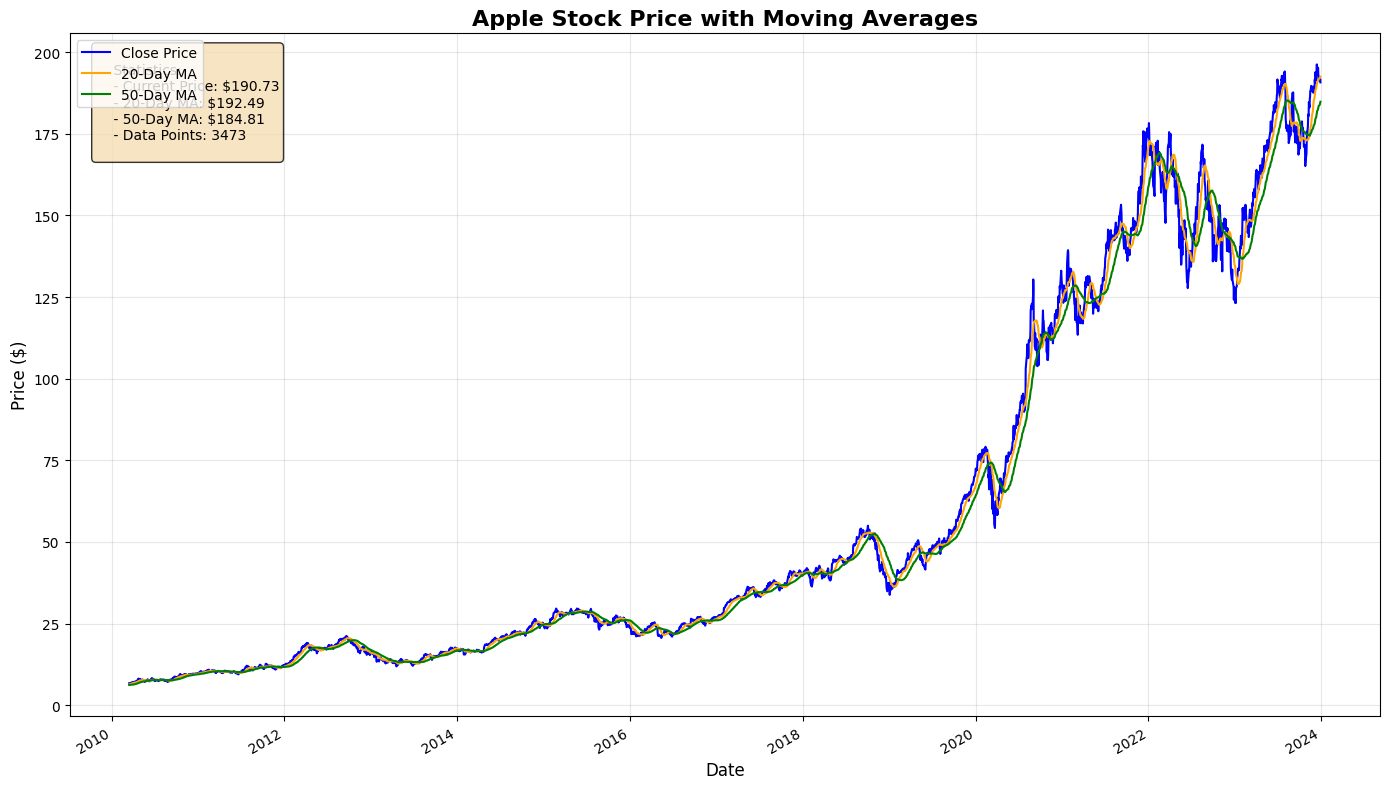

In [4]:
def create_static_price_chart(data):
    plt.figure(figsize=(14, 8))
    
    # Plot closing price
    plt.plot(data.index, data['Close'], label='Close Price', color='blue', linewidth=1.5)
    
    # Plot moving averages
    plt.plot(data.index, data['MA20'], label='20-Day MA', color='orange', linewidth=1.5)
    plt.plot(data.index, data['MA50'], label='50-Day MA', color='green', linewidth=1.5)
    
    # Customize the chart
    plt.title('Apple Stock Price with Moving Averages', fontsize=16, fontweight='bold')
    plt.xlabel('Date', fontsize=12)
    plt.ylabel('Price ($)', fontsize=12)
    plt.legend(loc='upper left')
    plt.grid(True, alpha=0.3)
    
    # Format the x-axis dates for better readability
    plt.gcf().autofmt_xdate()
    
    # Add a text box with statistics (fixed formatting)
    current_price = float(data["Close"].iloc[-1])
    ma20 = float(data["MA20"].iloc[-1])
    ma50 = float(data["MA50"].iloc[-1])
    
    stats_text = f'''
    Statistics:
    - Current Price: ${current_price:.2f}
    - 20-Day MA: ${ma20:.2f}
    - 50-Day MA: ${ma50:.2f}
    - Data Points: {len(data)}
    '''
    plt.text(0.02, 0.98, stats_text, transform=plt.gca().transAxes, fontsize=10,
             verticalalignment='top', bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.8))
    
    plt.tight_layout()
    plt.show()

# Create the static chart
create_static_price_chart(processed_data)

# 📊 *Additional Technical Indicators*


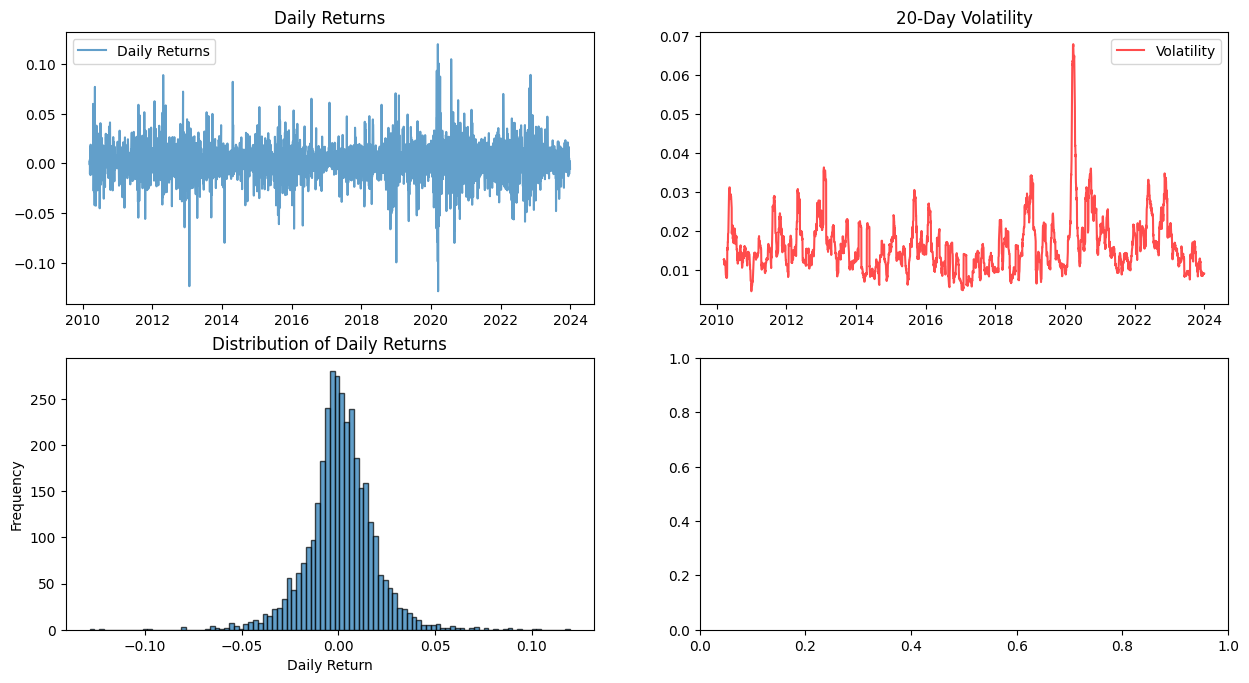

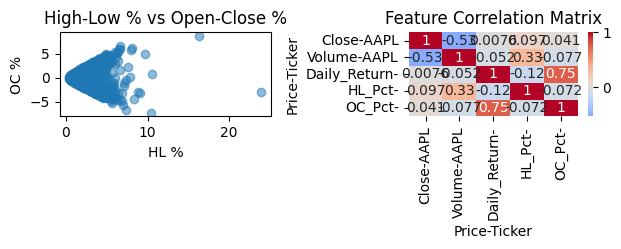

In [5]:
plt.figure(figsize=(15, 12))

plt.subplot(3, 2, 1)
plt.plot(processed_data['Daily_Return'], label='Daily Returns', alpha=0.7)
plt.title('Daily Returns')
plt.legend()

plt.subplot(3, 2, 2)
plt.plot(processed_data['Volatility'], label='Volatility', color='red', alpha=0.7)
plt.title('20-Day Volatility')
plt.legend()

plt.subplot(3, 2, 3)
plt.hist(processed_data['Daily_Return'].dropna(), bins=100, alpha=0.7, edgecolor='black')
plt.title('Distribution of Daily Returns')
plt.xlabel('Daily Return')
plt.ylabel('Frequency')

plt.subplot(3, 2, 4)
processed_data['Volume'].plot(logy=True, alpha=0.7)
plt.title('Trading Volume (Log Scale)')
plt.ylabel('Volume')

plt.subplot(3, 2, 5)
plt.scatter(processed_data['HL_Pct'], processed_data['OC_Pct'], alpha=0.5)
plt.title('High-Low % vs Open-Close %')
plt.xlabel('HL %')
plt.ylabel('OC %')

plt.subplot(3, 2, 6)
sns.heatmap(processed_data[['Close', 'Volume', 'Daily_Return', 'HL_Pct', 'OC_Pct']].corr(), 
            annot=True, cmap='coolwarm', center=0)
plt.title('Feature Correlation Matrix')

plt.tight_layout()
plt.show()

# **Prepare Dataset for LSTM**

In [6]:
class StockDataset(Dataset):
    def __init__(self, data, sequence_length=60, feature_columns=None):
        if feature_columns is None:
            feature_columns = ['Close', 'Volume', 'Daily_Return', 'HL_Pct', 'OC_Pct', 'MA20', 'Volatility']
        
        self.data = data[feature_columns].values
        self.target = data['Close'].values
        self.sequence_length = sequence_length
        
        if len(self.data) < sequence_length:
            raise ValueError(f"Data length ({len(self.data)}) is less than sequence length ({sequence_length})")
        
        self.scaler = RobustScaler()
        self.data_scaled = self.scaler.fit_transform(self.data)
        self.target_scaled = self.scaler.fit_transform(self.target.reshape(-1, 1))
        
        print(f" Dataset created with {len(self)} sequences")
        
    def __len__(self):
        return len(self.data_scaled) - self.sequence_length
    
    def __getitem__(self, idx):
        if idx < 0:
            idx = len(self) + idx
            
        if idx < 0 or idx >= len(self):
            raise IndexError(f"Index {idx} out of range for dataset of size {len(self)}")
        
        x = self.data_scaled[idx:idx+self.sequence_length]
        y = self.target_scaled[idx+self.sequence_length]
        
        return torch.FloatTensor(x), torch.FloatTensor(y)

try:
    feature_cols = ['Close', 'Volume', 'Daily_Return', 'HL_Pct', 'OC_Pct', 'MA20', 'MA50', 'Volatility']
    dataset = StockDataset(processed_data, sequence_length=60, feature_columns=feature_cols)
    print(f"📊 Dataset size: {len(dataset)} sequences")
    
    last_idx = len(dataset) - 1
    last_sequence, last_target = dataset[last_idx]
    print(f" Last sequence shape: {last_sequence.shape}")
    
except Exception as e:
    print(f" Error creating dataset: {e}")
    import traceback
    traceback.print_exc()

 Dataset created with 3413 sequences
📊 Dataset size: 3413 sequences
 Last sequence shape: torch.Size([60, 8])


# 🧪 **Train-Test Split**


In [7]:
train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size
train_dataset, test_dataset = torch.utils.data.random_split(dataset, [train_size, test_size])

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

print(f" Training samples: {len(train_dataset)}")
print(f" Test samples: {len(test_dataset)}")

 Training samples: 2730
 Test samples: 683


#  🧠 **Advanced LSTM Model Architecture**
---
 **Building a sophisticated neural network for time series prediction**

In [8]:
class AdvancedLSTM(nn.Module):
    def __init__(self, input_size, hidden_size=100, num_layers=3, dropout=0.3):
        super(AdvancedLSTM, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, 
                           batch_first=True, dropout=dropout, bidirectional=True)
        
        self.attention = nn.Sequential(
            nn.Linear(hidden_size * 2, 64),
            nn.Tanh(),
            nn.Linear(64, 1),
            nn.Softmax(dim=1)
        )
        
        self.fc = nn.Sequential(
            nn.Linear(hidden_size * 2, 50),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(50, 25),
            nn.ReLU(),
            nn.Dropout(0.1),
            nn.Linear(25, 1)
        )
        
    def forward(self, x):
        h0 = torch.zeros(self.num_layers * 2, x.size(0), self.hidden_size).to(x.device)
        c0 = torch.zeros(self.num_layers * 2, x.size(0), self.hidden_size).to(x.device)
        
        lstm_out, _ = self.lstm(x, (h0, c0))
        
        # Attention mechanism
        attention_weights = self.attention(lstm_out)
        context_vector = torch.sum(attention_weights * lstm_out, dim=1)
        
        out = self.fc(context_vector)
        return out

# Create model instance
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f" Using device: {device}")

 Using device: cuda


#  **Training the Advanced LSTM Model**


In [9]:
def train_model(model, train_loader, test_loader, num_epochs=100, learning_rate=0.001):
    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=1e-5)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=10, factor=0.5)
    
    train_losses = []
    test_losses = []
    
    model.to(device)
    
    for epoch in range(num_epochs):
        # Training
        model.train()
        train_loss = 0
        for batch_x, batch_y in train_loader:
            batch_x, batch_y = batch_x.to(device), batch_y.to(device)
            
            optimizer.zero_grad()
            outputs = model(batch_x)
            loss = criterion(outputs, batch_y)
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            optimizer.step()
            
            train_loss += loss.item()
        
        # Validation
        model.eval()
        test_loss = 0
        with torch.no_grad():
            for batch_x, batch_y in test_loader:
                batch_x, batch_y = batch_x.to(device), batch_y.to(device)
                outputs = model(batch_x)
                test_loss += criterion(outputs, batch_y).item()
        
        avg_train_loss = train_loss / len(train_loader)
        avg_test_loss = test_loss / len(test_loader)
        
        train_losses.append(avg_train_loss)
        test_losses.append(avg_test_loss)
        
        scheduler.step(avg_test_loss)
        
        if (epoch + 1) % 20 == 0:
            print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {avg_train_loss:.6f}, Test Loss: {avg_test_loss:.6f}')
    
    return train_losses, test_losses

# Initialize and train model
input_size = len(feature_cols)
model = AdvancedLSTM(input_size=input_size, hidden_size=128, num_layers=3, dropout=0.3)
print(f" Model Parameters: {sum(p.numel() for p in model.parameters()):,}")

train_losses, test_losses = train_model(model, train_loader, test_loader, num_epochs=100)

 Model Parameters: 962,504
Epoch [20/100], Train Loss: 0.010887, Test Loss: 0.001791
Epoch [40/100], Train Loss: 0.008576, Test Loss: 0.003166
Epoch [60/100], Train Loss: 0.007929, Test Loss: 0.002378
Epoch [80/100], Train Loss: 0.007834, Test Loss: 0.002238
Epoch [100/100], Train Loss: 0.007350, Test Loss: 0.002769


# 📉 **Plot Training Progress**


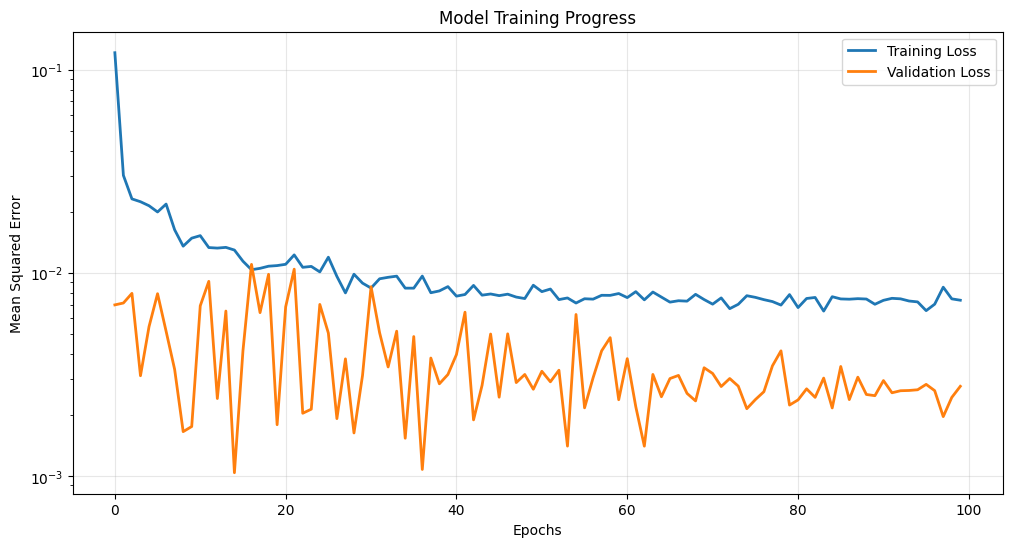

In [10]:
plt.figure(figsize=(12, 6))
plt.plot(train_losses, label='Training Loss', linewidth=2)
plt.plot(test_losses, label='Validation Loss', linewidth=2)
plt.title('Model Training Progress')
plt.xlabel('Epochs')
plt.ylabel('Mean Squared Error')
plt.legend()
plt.grid(True, alpha=0.3)
plt.yscale('log')
plt.show()

#  **Make Predictions**


In [11]:
def make_predictions(model, data_loader):
    model.eval()
    predictions = []
    actuals = []
    
    with torch.no_grad():
        for batch_x, batch_y in data_loader:
            batch_x = batch_x.to(device)
            batch_preds = model(batch_x).cpu().numpy()
            
            predictions.extend(batch_preds.flatten())
            actuals.extend(batch_y.numpy().flatten())
    
    return np.array(predictions), np.array(actuals)

test_predictions, test_actuals = make_predictions(model, test_loader)

# Inverse transform predictions
test_predictions_original = dataset.scaler.inverse_transform(
    test_predictions.reshape(-1, 1)).flatten()
test_actuals_original = dataset.scaler.inverse_transform(
    test_actuals.reshape(-1, 1)).flatten()

# 📊 **Evaluate Model Performance**


In [12]:
def evaluate_predictions(actual, predicted):
    mse = mean_squared_error(actual, predicted)
    mae = mean_absolute_error(actual, predicted)
    rmse = np.sqrt(mse)
    r2 = r2_score(actual, predicted)
    
    # Calculate percentage errors
    mape = np.mean(np.abs((actual - predicted) / actual)) * 100
    
    metrics = {
        'MSE': mse,
        'MAE': mae,
        'RMSE': rmse,
        'R² Score': r2,
        'MAPE (%)': mape
    }
    
    return metrics

metrics = evaluate_predictions(test_actuals_original, test_predictions_original)

print(" Model Performance Metrics:")
for metric, value in metrics.items():
    print(f"{metric}: {value:.4f}" if metric != 'MAPE (%)' else f"{metric}: {value:.2f}%")

 Model Performance Metrics:
MSE: 16.3732
MAE: 2.4034
RMSE: 4.0464
R² Score: 0.9947
MAPE (%): 4.35%


# 📈 **Visualize Predictions vs Actual**


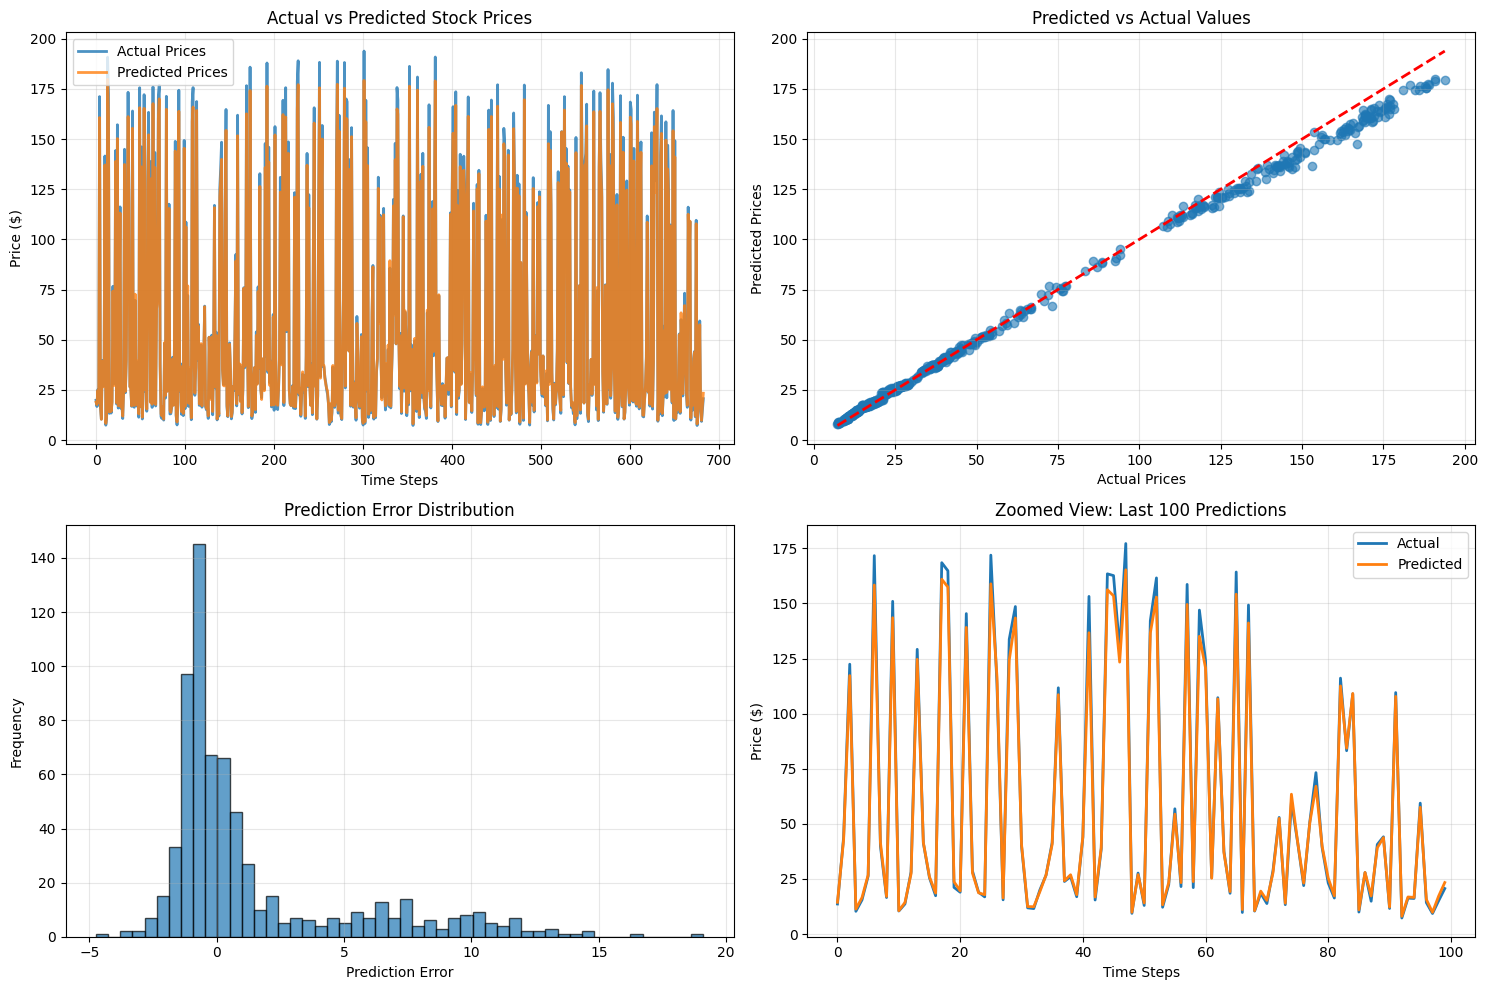

In [13]:
plt.figure(figsize=(15, 10))

# Plot 1: Overall predictions
plt.subplot(2, 2, 1)
plt.plot(test_actuals_original, label='Actual Prices', linewidth=2, alpha=0.8)
plt.plot(test_predictions_original, label='Predicted Prices', linewidth=2, alpha=0.8)
plt.title('Actual vs Predicted Stock Prices')
plt.xlabel('Time Steps')
plt.ylabel('Price ($)')
plt.legend()
plt.grid(True, alpha=0.3)

# Plot 2: Scatter plot
plt.subplot(2, 2, 2)
plt.scatter(test_actuals_original, test_predictions_original, alpha=0.6)
plt.plot([min(test_actuals_original), max(test_actuals_original)], 
         [min(test_actuals_original), max(test_actuals_original)], 
         'r--', linewidth=2)
plt.title('Predicted vs Actual Values')
plt.xlabel('Actual Prices')
plt.ylabel('Predicted Prices')
plt.grid(True, alpha=0.3)

# Plot 3: Error distribution
plt.subplot(2, 2, 3)
errors = test_actuals_original - test_predictions_original
plt.hist(errors, bins=50, alpha=0.7, edgecolor='black')
plt.title('Prediction Error Distribution')
plt.xlabel('Prediction Error')
plt.ylabel('Frequency')
plt.grid(True, alpha=0.3)

# Plot 4: Zoomed-in section
plt.subplot(2, 2, 4)
zoom_range = 100  # Show last 100 points
plt.plot(test_actuals_original[-zoom_range:], label='Actual', linewidth=2)
plt.plot(test_predictions_original[-zoom_range:], label='Predicted', linewidth=2)
plt.title('Zoomed View: Last 100 Predictions')
plt.xlabel('Time Steps')
plt.ylabel('Price ($)')
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

#  **Future Price Prediction***


In [14]:
def predict_future_prices(model, dataset, days=30):
    model.eval()
    future_predictions = []
    
    last_idx = len(dataset) - 1
    last_sequence, last_target = dataset[last_idx]
    
    print(f"📊 Using sequence from index {last_idx}, shape: {last_sequence.shape}")
    
    current_sequence = last_sequence.clone().detach()
    current_sequence = current_sequence.to(device)
    
    with torch.no_grad():
        for day in range(days):
            input_seq = current_sequence.unsqueeze(0)
            
            prediction = model(input_seq)
            future_predictions.append(prediction.item())
            
            new_row = current_sequence[-1].clone()
            new_row[0] = prediction.item()  
            
            current_sequence = torch.cat([current_sequence[1:], new_row.unsqueeze(0)])
            
            print(f" Day {day+1}: Predicted ${prediction.item():.2f}, Sequence shape: {current_sequence.shape}")
    
    return np.array(future_predictions)

try:
    print("🔮 Starting future price prediction...")
    future_predictions = predict_future_prices(model, dataset, days=30)
    
    if len(future_predictions) > 0:
        future_predictions_original = dataset.scaler.inverse_transform(
            future_predictions.reshape(-1, 1)).flatten()

        print(" Next 30 Days Predictions:")
        for i, price in enumerate(future_predictions_original, 1):
            print(f"Day {i}: ${price:.2f}")
    else:
        print(" No predictions were generated")
        
except Exception as e:
    print(f" Error in prediction: {e}")
    import traceback
    traceback.print_exc()

🔮 Starting future price prediction...
📊 Using sequence from index 3412, shape: torch.Size([60, 8])
 Day 1: Predicted $1.96, Sequence shape: torch.Size([60, 8])
 Day 2: Predicted $1.96, Sequence shape: torch.Size([60, 8])
 Day 3: Predicted $1.96, Sequence shape: torch.Size([60, 8])
 Day 4: Predicted $1.96, Sequence shape: torch.Size([60, 8])
 Day 5: Predicted $1.95, Sequence shape: torch.Size([60, 8])
 Day 6: Predicted $1.95, Sequence shape: torch.Size([60, 8])
 Day 7: Predicted $1.95, Sequence shape: torch.Size([60, 8])
 Day 8: Predicted $1.95, Sequence shape: torch.Size([60, 8])
 Day 9: Predicted $1.95, Sequence shape: torch.Size([60, 8])
 Day 10: Predicted $1.95, Sequence shape: torch.Size([60, 8])
 Day 11: Predicted $1.96, Sequence shape: torch.Size([60, 8])
 Day 12: Predicted $1.96, Sequence shape: torch.Size([60, 8])
 Day 13: Predicted $1.96, Sequence shape: torch.Size([60, 8])
 Day 14: Predicted $1.96, Sequence shape: torch.Size([60, 8])
 Day 15: Predicted $1.96, Sequence shape: 

In [15]:

from datetime import datetime, timedelta

# Set style for better appearance
plt.style.use('default')
plt.rcParams['figure.figsize'] = (14, 8)
plt.rcParams['font.size'] = 12

# 📈 **Create static future prediction plot**


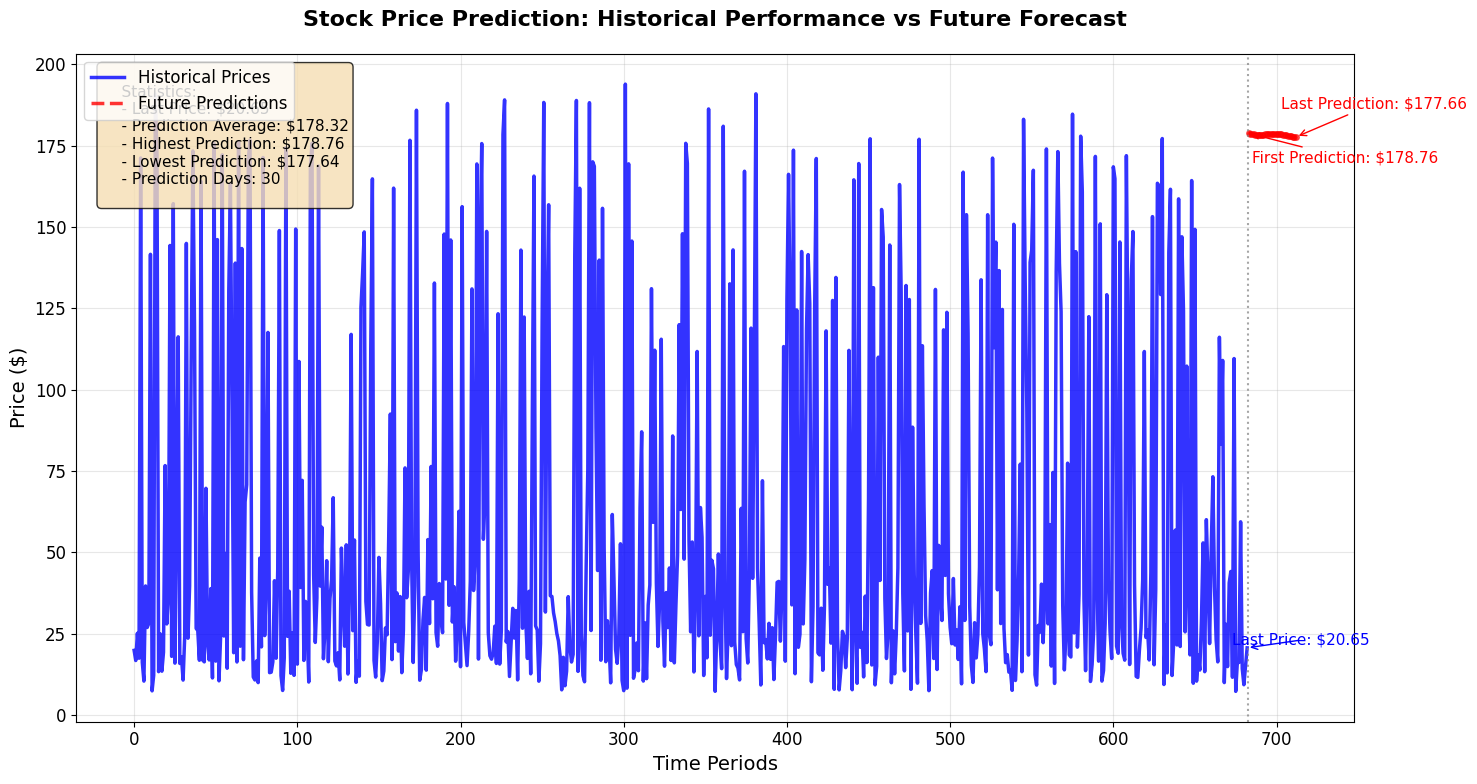

In [16]:
def create_static_future_plot(actual_prices, future_predictions, actual_dates=None):
    fig, ax = plt.subplots(figsize=(15, 8))
    
    # Plot historical prices
    historical_range = range(len(actual_prices))
    ax.plot(historical_range, actual_prices, 'b-', linewidth=2.5, label='Historical Prices', alpha=0.8)
    
    # Plot future predictions
    future_start = len(actual_prices)
    future_range = range(future_start, future_start + len(future_predictions))
    ax.plot(future_range, future_predictions, 'r--', linewidth=2.5, label='Future Predictions', alpha=0.8)
    ax.plot(future_range, future_predictions, 'ro', markersize=4, alpha=0.6)
    
    # Add vertical line to separate historical and future data
    ax.axvline(x=future_start - 0.5, color='gray', linestyle=':', alpha=0.7)
    
    # Add labels and title
    ax.set_title('Stock Price Prediction: Historical Performance vs Future Forecast', fontsize=16, fontweight='bold', pad=20)
    ax.set_xlabel('Time Periods', fontsize=14)
    ax.set_ylabel('Price ($)', fontsize=14)
    
    # Add grid for better readability
    ax.grid(True, alpha=0.3)
    
    # Add legend
    ax.legend(loc='upper left', fontsize=12)
    
    # Add value annotations for important points
    # Last actual value
    last_actual = actual_prices[-1]
    ax.annotate(f'Last Price: ${last_actual:.2f}', 
                xy=(len(actual_prices)-1, last_actual),
                xytext=(len(actual_prices)-10, last_actual * 1.05),
                arrowprops=dict(arrowstyle='->', color='blue'),
                fontsize=11, color='blue')
    
    # First future prediction
    first_future = future_predictions[0]
    ax.annotate(f'First Prediction: ${first_future:.2f}', 
                xy=(future_start, first_future),
                xytext=(future_start+2, first_future * 0.95),
                arrowprops=dict(arrowstyle='->', color='red'),
                fontsize=11, color='red')
    
    # Last future prediction
    last_future = future_predictions[-1]
    ax.annotate(f'Last Prediction: ${last_future:.2f}', 
                xy=(future_start + len(future_predictions)-1, last_future),
                xytext=(future_start + len(future_predictions)-10, last_future * 1.05),
                arrowprops=dict(arrowstyle='->', color='red'),
                fontsize=11, color='red')
    
    # Add statistics box
    stats_text = f'''
    Statistics:
    - Last Price: ${last_actual:.2f}
    - Prediction Average: ${np.mean(future_predictions):.2f}
    - Highest Prediction: ${np.max(future_predictions):.2f}
    - Lowest Prediction: ${np.min(future_predictions):.2f}
    - Prediction Days: {len(future_predictions)}
    '''
    ax.text(0.02, 0.98, stats_text, transform=ax.transAxes, fontsize=11,
            verticalalignment='top', bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.8))
    
    # Adjust layout to prevent clipping
    plt.tight_layout()
    
    return fig

# Create static plot
fig = create_static_future_plot(test_actuals_original, future_predictions_original)
plt.show()

# **Create prediction table**


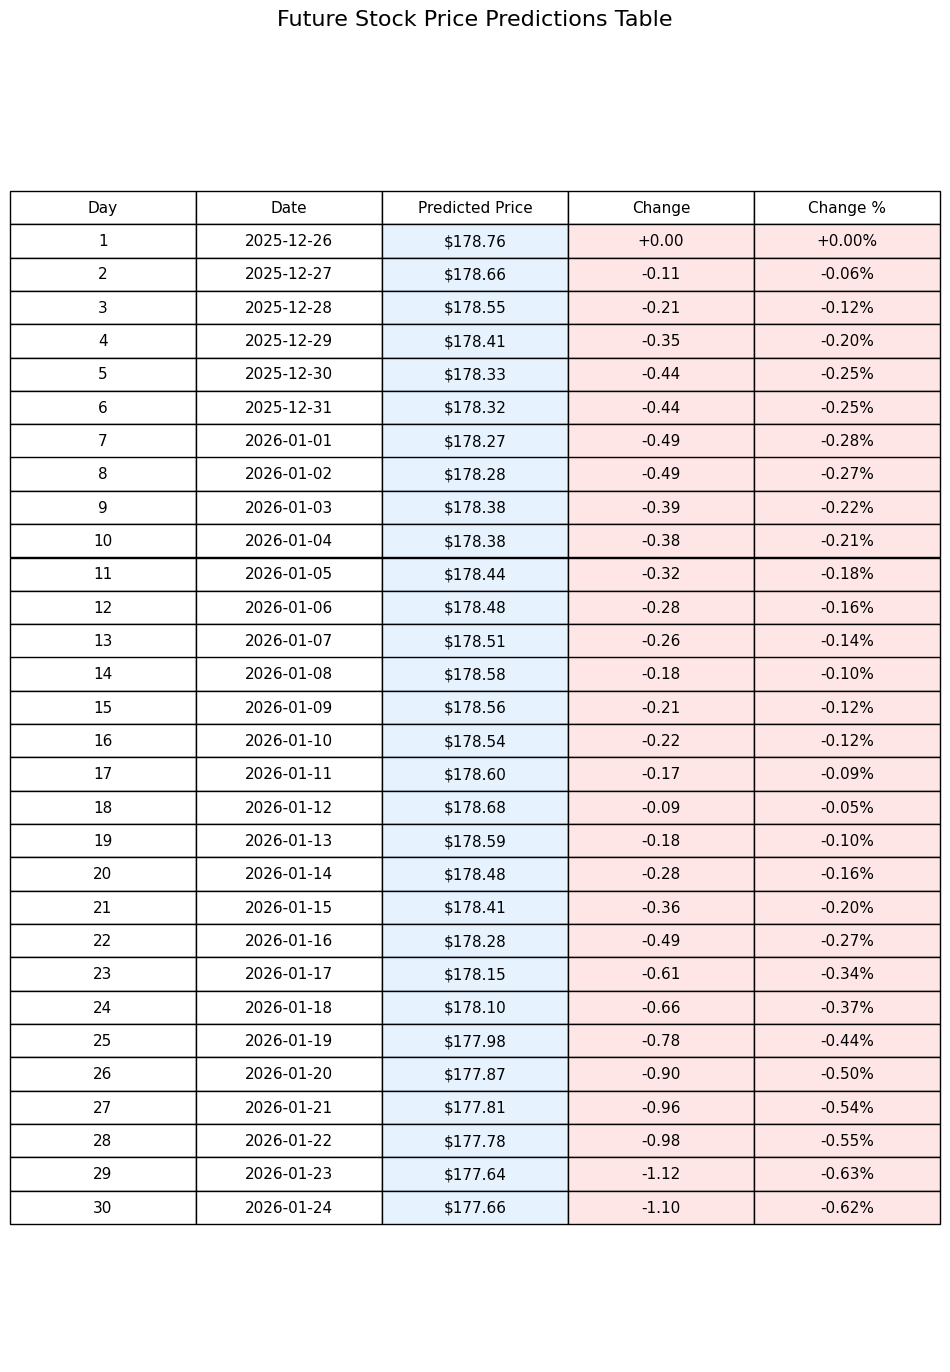

In [17]:
def create_prediction_table(future_predictions):
    # Create dates (can be adjusted as needed)
    start_date = datetime.now().date()
    dates = [start_date + timedelta(days=i) for i in range(len(future_predictions))]
    
    # Create prediction data
    prediction_data = []
    for i, (date, price) in enumerate(zip(dates, future_predictions), 1):
        change = price - future_predictions[0]  # Change from first day
        change_pct = (change / future_predictions[0]) * 100
        prediction_data.append([i, date.strftime('%Y-%m-%d'), f'${price:.2f}', 
                               f'{change:+.2f}', f'{change_pct:+.2f}%'])
    
    # Create table plot
    fig, ax = plt.subplots(figsize=(12, len(future_predictions) * 0.5 + 2))
    ax.axis('tight')
    ax.axis('off')
    
    # Create table
    table = ax.table(cellText=prediction_data,
                     colLabels=['Day', 'Date', 'Predicted Price', 'Change', 'Change %'],
                     cellLoc='center',
                     loc='center')
    
    # Format table
    table.auto_set_font_size(False)
    table.set_fontsize(11)
    table.scale(1, 2)
    
    # Color cells
    for i in range(1, len(prediction_data) + 1):
        for j in range(5):
            cell = table[i, j]
            if j == 2:  # Price column
                cell.set_facecolor('#E6F3FF')
            elif j in [3, 4]:  # Change columns
                change = float(prediction_data[i-1][3].replace('+', ''))
                if change > 0:
                    cell.set_facecolor('#E6FFE6')  # Green for positive
                else:
                    cell.set_facecolor('#FFE6E6')  # Red for negative
    
    plt.title('Future Stock Price Predictions Table', fontsize=16, pad=20)
    return fig

# Create and display prediction table
table_fig = create_prediction_table(future_predictions_original)
plt.show()

# 📉 **Create daily change plot**


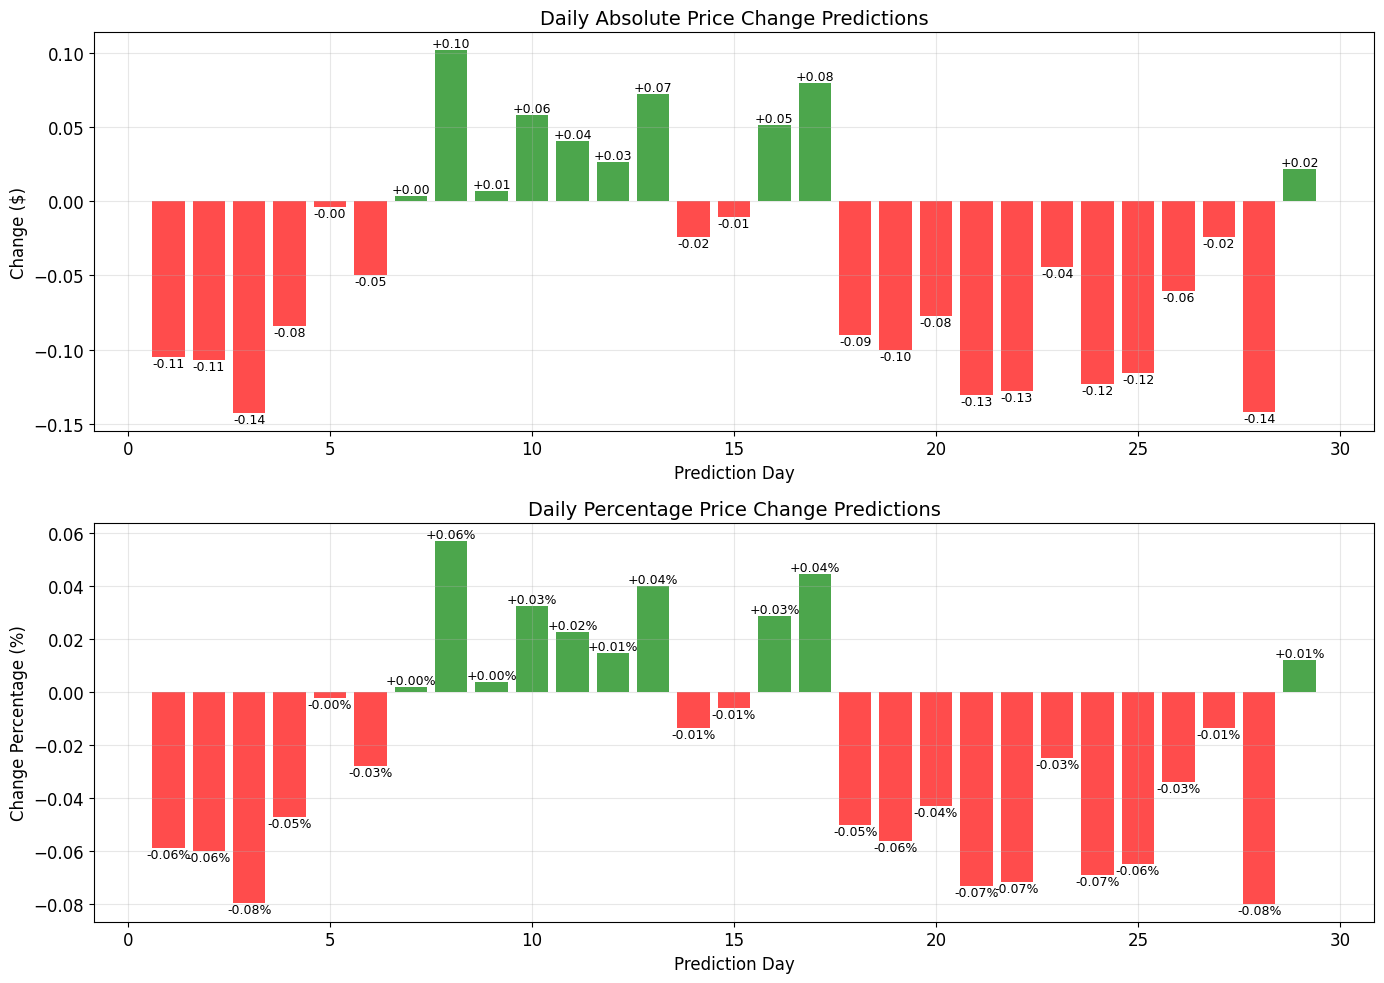

In [18]:
def create_daily_change_plot(future_predictions):
    # Calculate daily changes
    daily_changes = np.diff(future_predictions)
    daily_change_pct = (daily_changes / future_predictions[:-1]) * 100
    
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(14, 10))
    
    # First plot: Absolute changes
    bars = ax1.bar(range(1, len(daily_changes) + 1), daily_changes, 
                   color=['green' if x >= 0 else 'red' for x in daily_changes],
                   alpha=0.7)
    ax1.set_title('Daily Absolute Price Change Predictions', fontsize=14)
    ax1.set_xlabel('Prediction Day')
    ax1.set_ylabel('Change ($)')
    ax1.grid(True, alpha=0.3)
    
    # Add values on bars
    for i, bar in enumerate(bars):
        height = bar.get_height()
        ax1.text(bar.get_x() + bar.get_width()/2., height,
                f'{height:+.2f}',
                ha='center', va='bottom' if height >= 0 else 'top', fontsize=9)
    
    # Second plot: Percentage changes
    bars2 = ax2.bar(range(1, len(daily_change_pct) + 1), daily_change_pct,
                    color=['green' if x >= 0 else 'red' for x in daily_change_pct],
                    alpha=0.7)
    ax2.set_title('Daily Percentage Price Change Predictions', fontsize=14)
    ax2.set_xlabel('Prediction Day')
    ax2.set_ylabel('Change Percentage (%)')
    ax2.grid(True, alpha=0.3)
    
    # Add values on bars
    for i, bar in enumerate(bars2):
        height = bar.get_height()
        ax2.text(bar.get_x() + bar.get_width()/2., height,
                f'{height:+.2f}%',
                ha='center', va='bottom' if height >= 0 else 'top', fontsize=9)
    
    plt.tight_layout()
    return fig

# Create and display change plot
change_fig = create_daily_change_plot(future_predictions_original)
plt.show()